Link for the pre-processed Datasets:

[Celeb-DF Fake processed videos](https://drive.google.com/drive/folders/1SxCb_Wr7N4Wsc-uvjUl0i-6PpwYmwN65)

[Celeb-DF Real processed videos](https://drive.google.com/drive/folders/1g97v9JoD3pCKA2TxHe8ZLRe4buX2siCQ)

[FaceForensics++ Real and fake processed videos](https://drive.google.com/drive/folders/1VIIWRLs6VBXRYKODgeOU7i6votLPPxT0)

[DFDC Fake processed videos](https://drive.google.com/drive/folders/1yz3DBeFJvZ_QzWsyY7EwBNm7fx4MiOfF)

[DFDC Real processed videos](https://drive.google.com/drive/folders/1wN3ZOd0WihthEeH__Lmj_ENhoXJN6U11)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Command to connect to local runtime
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [3]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 1.3 MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=6d3bd2e1969411d52bc5d1b67664dd23b98dcca86d6a0d9ee8d70972a4010eed
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [1]:
import json
import glob
import numpy as np
import cv2
import copy
import random
import cv2 as cv
from matplotlib import pyplot as plt
import os
import matplotlib.pyplot as plt
import face_recognition
import random
import keras
import math
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.layers import LSTM
from scipy import stats as s
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
#Adding the datasets 
#Change the path to the specified datasets accordingly

#DFDC Dataset 
#video_files = glob.glob('/content/drive/MyDrive/FinalDatasets/DFDC_FAKE_Face_only_data/*.mp4')
#video_files += glob.glob('/content/drive/MyDrive/FinalDatasets/DFDC_REAL_Face_only_data/*.mp4')

#Uncomment for Celeb DF dataset
video_files = glob.glob('/content/drive/MyDrive/FinalDatasets/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/FinalDatasets/Celeb_real_face_only/*.mp4')

#Uncomment for FaceForensics++ Dataset
#video_files = glob.glob('/content/drive/MyDrive/FinalDatasets/FF_Face_only_data/*.mp4')

random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []

#calculating the total videos in the complete dataset and average frames per video
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<148):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 14

In [3]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  #Change the path to Gobal_metadata.csv file accordingly
  lab = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


samples=[]
label_lists=[] 

def get_opticalflow(file,frame_per_video) :
  # The video feed is read in as a VideoCapture object
  cap = cv.VideoCapture(file)

  #splitting the file path to get the names of the videos
  #change the split function according to your file path
  temp_video = file.split('/')[-1]

  #Change the path to Gobal_metadata.csv file accordingly
  labels = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

  #getting the labels from Gobal_metadata.csv file
  label = labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
  if(label == 'FAKE'):
    label = 0
  if(label == 'REAL'):
    label = 1
  
  # ret = a boolean return value from
  # getting the frame, first_frame = the
  # first frame in the entire video sequence
  ret, first_frame = cap.read()

  # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
  prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

  # Creates an image filled with zero
  # intensities with the same dimensions
  # as the frame
  mask = np.zeros_like(first_frame)

  #setting the frame count to 0
  count=0
  # Sets image saturation to maximum
  mask[..., 1] = 255
  
  while(cap.isOpened()):

    # ret = a boolean return value from getting
    # the frame, frame = the current frame being
    # projected in the video
    ret, frame = cap.read()
    
    if ret==True:
      #appending the labels of the frames
      label_lists.append(label)
      
      # Converts each frame to grayscale - we previously
      # only converted the first frame to grayscale
      gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
      # Calculates dense optical flow by Farneback method
      flow = cv.calcOpticalFlowFarneback(prev_gray, gray,
                    None,
                    0.5, 3, 15, 3, 5, 1.2, 0)
    
      # Computes the magnitude and angle of the 2D vectors
      magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
      # Sets image hue according to the optical flow
      # direction
      mask[..., 0] = angle * 180 / np.pi / 2
    
      # Sets image value according to the optical flow
      # magnitude (normalized)
      mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    
      # Converts HSV to RGB (BGR) color representation
      rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    
      #appending the rgb frames to samples
      samples.append(rgb)
 
      # Updates previous frame
      prev_gray = gray

    #updates the frame count
    count=count+1
    
    #if the frame_count limit is reached the loop breaks and moves to next video
    if count==frame_per_video:
      break

  # The following frees up resources and
  # closes all windows
  cap.release()
  cv.destroyAllWindows()
  

In [5]:
header_list = ["file","label"]
#Change the path to Gobal_metadata.csv file accordingly
labels = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

#splitting the video_files into train_videos and valis_videos in 80:20 ratio
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]

print("TOTAL TRAIN VIDEOS : " , len(train_videos))
print("TOTAL TEST VIDEOS : " , len(valid_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])



TOTAL TRAIN VIDEOS :  928
TOTAL TEST VIDEOS :  233
TRAIN:  Real: 468  Fake: 460
TEST:  Real: 119  Fake: 114


In [6]:
import numpy as np

#defining the number of frames to retrieve from each video
frame_per_video=148

#Generating the optical flow of the videos in train_videos
for i in train_videos:
  get_opticalflow(i,frame_per_video)

#converting the samples(frames list) to numpy array
x=np.array(samples) 
print('shape of x:')
print(x.shape)  

shape of x:
(9280, 112, 112, 3)


In [7]:
y = label_lists

#creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, stratify = y)

In [8]:
#printing the shape of X_train
X_train.shape

(7424, 112, 112, 3)

In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [10]:
# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

In [11]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

(7424, 3, 3, 512)

In [12]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(1856, 3, 3, 512)

In [15]:
# reshaping the training as well as validation frames in single dimension
# change the shapes of X_train and X_test accordingly
X_train = X_train.reshape(X_train.shape[0], 3*3*512)
X_test = X_test.reshape(X_test.shape[0], 3*3*512)

In [16]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

The input shape will be 4608, which is the shape of our images

In [21]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(4608,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [22]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [23]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [24]:
# training the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Epoch 1/30
58/58 [==============================] - 1s 11ms/step - loss: 0.6951 - accuracy: 0.5170 - val_loss: 0.6915 - val_accuracy: 0.5102
Epoch 2/30
58/58 [==============================] - 0s 7ms/step - loss: 0.6769 - accuracy: 0.5669 - val_loss: 0.6593 - val_accuracy: 0.6110
Epoch 3/30
58/58 [==============================] - 1s 14ms/step - loss: 0.6504 - accuracy: 0.6255 - val_loss: 0.6443 - val_accuracy: 0.6272
Epoch 4/30
58/58 [==============================] - 0s 8ms/step - loss: 0.6219 - accuracy: 0.6568 - val_loss: 0.6412 - val_accuracy: 0.6288
Epoch 5/30
58/58 [==============================] - 0s 8ms/step - loss: 0.5868 - accuracy: 0.6899 - val_loss: 0.6412 - val_accuracy: 0.6175
Epoch 6/30
58/58 [==============================] - 0s 5ms/step - loss: 0.5371 - accuracy: 0.7373 - val_loss: 0.6419 - val_accuracy: 0.6342
Epoch 7/30
58/58 [==============================] - 0s 5ms/step - loss: 0.4782 - accuracy: 0.7741 - val_loss: 0.7665 - val_accuracy: 0.6137
Epoch 8/30
58/58 [

Evaluating our Model

In [25]:
# loading the trained weights 
#Enter the path accordingly
model.load_weights("weight.hdf5")

In [26]:
# creating dataframe for actual labels of the valid_videos
valid_label =[]

for video_file in valid_videos :
    count = 0
    videoFile = video_file
    cap = cv2.VideoCapture(video_file)   # capturing the video from the given path

    # Splitting the file path of videos to get their names 
    #can be changed accordingly
    temp_video = video_file.split('/')[-1] 

    # Change the path to Gobal_metadata.csv accordingly
    labels = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)
    label = labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      label = 0
    if(label == 'REAL'):
      label = 1
    label_str = str(label)
    valid_label.append(label_str)
            
df = pd.DataFrame(valid_label)
y = pd.get_dummies(df)

While re-running the code, execute predit.clear to clear the list of previously predicted labels

In [30]:
predict=[]

def predicting(file,frame_per_video) :
  prediction_images=[]
  count=0 
  # The video feed is read in as
  # a VideoCapture object
  cap = cv.VideoCapture(file)
  
  # ret = a boolean return value from
  # getting the frame, first_frame = the
  # first frame in the entire video sequence
  ret, first_frame = cap.read()

  # Converts frame to grayscale because we
  # only need the luminance channel for
  # detecting edges - less computationally
  # expensive
  prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

  # Creates an image filled with zero
  # intensities with the same dimensions
  # as the frame
  mask = np.zeros_like(first_frame)
  
  # Sets image saturation to maximum
  mask[..., 1] = 255
  
  while(cap.isOpened()):
    
    # ret = a boolean return value from getting
    # the frame, frame = the current frame being
    # projected in the video
    ret, frame = cap.read()
    
    if ret==True:
    
      # Converts each frame to grayscale - we previously
      # only converted the first frame to grayscale
      gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
      # Calculates dense optical flow by Farneback method
      flow = cv.calcOpticalFlowFarneback(prev_gray, gray,
                    None,
                    0.5, 3, 15, 3, 5, 1.2, 0)
    
      # Computes the magnitude and angle of the 2D vectors
      magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    
      # Sets image hue according to the optical flow direction
      mask[..., 0] = angle * 180 / np.pi / 2
    
      # Sets image value according to the optical flow magnitude (normalized)
      mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    
      # Converts HSV to RGB (BGR) color representation
      rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    
      #appending the rgb images 
      prediction_images.append(rgb)
    
      # Updates previous frame
      prev_gray = gray
    count=count+1
    # Frames are read by intervals of 1 millisecond. The
    # programs breaks out of the while loop when the
    # user presses the 'q' key
    if count==frame_per_video:
      break

  # The following frees up resources and closes all windows
  cap.release()
  cv.destroyAllWindows()
  # converting all the frames for a test video into numpy array
  prediction_images = np.array(prediction_images)

  # extracting features using pre-trained model
  prediction_images = base_model.predict(prediction_images)

  # converting features in one dimensional array
  prediction_images = prediction_images.reshape(prediction_images.shape[0], 3*3*512)

  # predicting tags for each array
  prediction = np.argmax(model.predict(prediction_images),axis=-1)

  prediction_new= pd.DataFrame(prediction)
  g = s.mode(prediction_new)[0][0]
  k=g[0]
  # appending the mode of predictions in predict list to assign the tag to the video
  predict.append(y.columns.values[k].split('_')[-1])
  
  

In [31]:
#predicting the videos over the trained model
for i in valid_videos :
  predicting(i,frame_per_video)

shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of prediction image : 
(10, 3, 3, 512)
shape of p

In [32]:
accuracy_metric=accuracy_score(predict, valid_label)
print("Accuracy score : ", accuracy_metric*100)

precision_metric=precision_score(valid_label, predict, average = "macro")
print("Precision score : ", precision_metric*100)

recall_metric = recall_score(valid_label, predict, average = "macro")
print("Recall score : ",recall_metric*100)


f1_metric = f1_score(valid_label, predict, average = "macro")
print("F1 score : ", f1_metric*100)

# calculate roc curve
#fpr, tpr, thresholds = roc_curve(valid_label, predict)
# calculate AUC
auc = roc_auc_score(valid_label, predict)
print("ROC AUC score : ",auc)

Accuracy score :  57.08154506437768
Precision score :  57.08994708994709
Recall score :  56.914344685242526
F1 score :  56.73005496954391
ROC AUC score :  0.5691434468524251


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


In [33]:
valid_label = [int(i) for i in valid_label]
predict = [int(i) for i in predict]

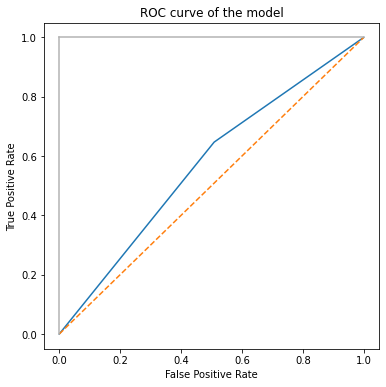

In [34]:
lr_fpr, lr_tpr, _ = roc_curve(valid_label, predict)
plt.subplots(1, figsize=(6,6))
plt.title('ROC curve of the model')
plt.plot(lr_fpr, lr_tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()